In [1]:
import torch;
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import pandas as pd
import torchvision.models as models 
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim import lr_scheduler
import seaborn as sns
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import copy
from tqdm import tqdm
#from model import VAE

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from dataloader import *
from model import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
#only on validation set
csv_path = 'progress.csv'
img_path = '/home/vip/sayan-mandal/datasets/obj_criteria/good_reduced/'

CDL = CLUnivDataLoader(csv_path, img_path, transform = transforms.Compose([transforms.Resize(64),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),timestep=3,n=2)

#random sampler
batch_size = 64
validation_split = .2
test_split = .2
train_split = 1-validation_split-test_split
shuffle_dataset = True

# Creating data indices for training and validation splits:
dataset_size = len(CDL)
indices = list(range(dataset_size))
split_train = int(np.floor(train_split * dataset_size))
split_valid = int(np.floor((train_split+validation_split) * dataset_size))
if shuffle_dataset :
    np.random.shuffle(indices)
train_indices, val_indices, test_indices =  indices[:split_train],indices[split_train:split_valid],indices[split_valid:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=test_sampler)

<AxesSubplot:xlabel='Slope ($\\mu$m/y)', ylabel='Count'>

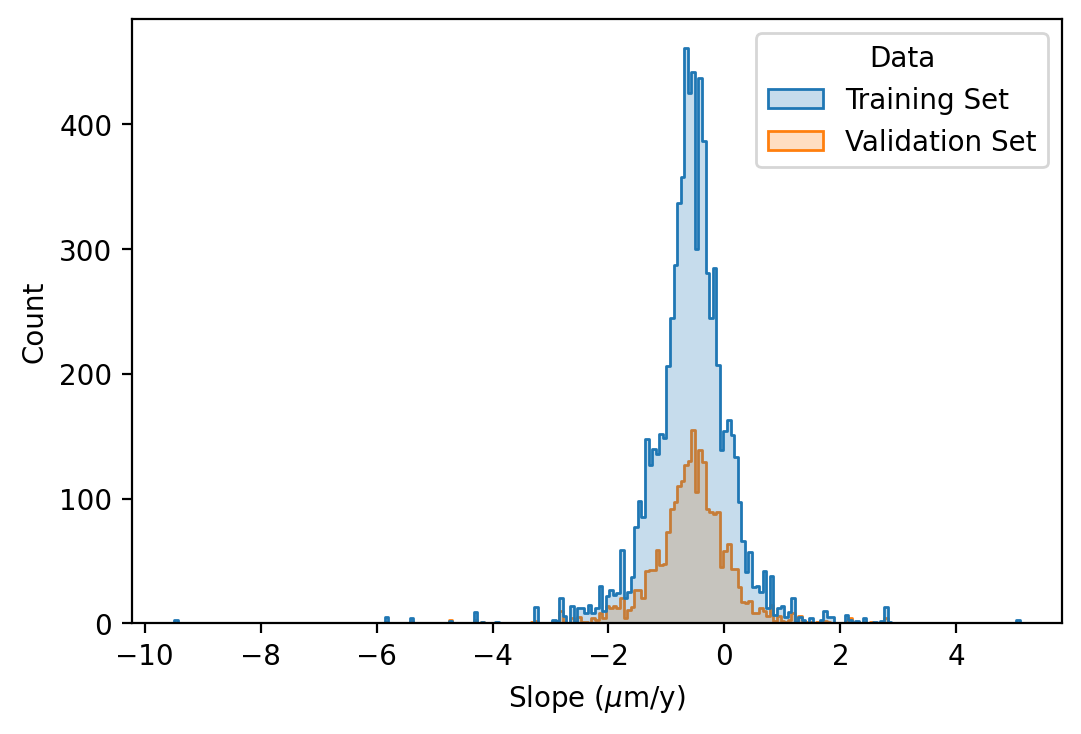

In [4]:

for batch_idx, (_, targets, _) in enumerate(train_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        true_scores = targets.cpu().numpy()
    else:
        true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)

for batch_idx, (_, targets, _) in enumerate(valid_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        valtrue_scores = targets.cpu().numpy()
    else:
        valtrue_scores = np.append(valtrue_scores, targets.cpu().numpy(), axis = 0)

from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': true_scores.ravel().tolist(), 'Data':'Training Set'})
dfy = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': valtrue_scores.ravel().tolist(), 'Data':'Validation Set'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='Slope ($\mu$m/y)',hue='Data',ax=ax, element='step')


In [5]:
print(len(true_scores), len(valtrue_scores))

7759 2586


In [6]:
torch.cuda.empty_cache()
tl = iter(train_loader)
dat,_,_ = next(tl)
bs, ts, C, H, W = dat.shape
n_out = 1
print(ts)

model = CNNLSTMNet(channels = C, ts = ts, n_out = n_out, device = device).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)  #,momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[120], gamma= 0.1)
criterion = nn.MSELoss()  # this is for regression mean squared loss

3


In [7]:
epochs = 200
best_loss =float('inf')
ep, trainloss, validloss, testloss = [],[],[],[]
testep, totloss = [],[]
besttrloss, bestvalloss, besttsloss = 0,0,0
for epoch in range(1,epochs+1):
    model.train()
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    trloss = 0
    for batch_idx, (data, targets, _) in loop:
        optimizer.zero_grad() 
        data = Variable(data).to(device)
        targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

        #forward pass
        scores = model(data)
        loss = criterion(scores, targets)
        trloss += loss.item()
        #backward pass   
        loss.backward()

        #gradient descent
        optimizer.step()
        loop.set_description(f"Epoch [{epoch}/{epochs}]")
        loop.set_postfix(batch_loss = loss.item(), running_loss = trloss )
    scheduler.step()

    model.eval()
    valloss = 0
    with torch.no_grad():
        for data, targets, _ in valid_loader:
            data = Variable(data).to(device)
            targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

            
            scores = model(data)
            loss = criterion(scores, targets)

            valloss += loss.item()

    if valloss < best_loss:
        tsloss = 0
        with torch.no_grad():
            for data, targets, _ in test_loader:
                data = Variable(data).to(device)
                targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

                
                scores = model(data)
                loss = criterion(scores, targets)

                tsloss += loss.item()
            testloss += [tsloss]
            testep += [epoch]
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f} ===========> {:.4f} | Test Loss: {:.4f} | Saving model...".format(trloss, best_loss, valloss, tsloss)
        best_loss = valloss
        bestvalloss = valloss
        besttrloss = trloss
        besttsloss = tsloss
        best_e = epoch
        torch.save(model.state_dict(),'state_dict_ts3_2.pt')
        #best_model = copy.deepcopy(model)
    else:
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f}".format(trloss, valloss)

    print(to_print)
    ep+=[epoch]
    trainloss += [trloss]
    validloss += [valloss]
    totloss += [trloss + valloss]

Epoch [1/200]: 100%|██████████| 122/122 [00:22<00:00,  5.40it/s, batch_loss=1.18, running_loss=64.4]


Train Loss: 64.3921 | Valid Loss: inf ===========> 20.5223 | Test Loss: 23.9669 | Saving model...


Epoch [2/200]: 100%|██████████| 122/122 [00:22<00:00,  5.43it/s, batch_loss=0.245, running_loss=62.7]


Train Loss: 62.7289 | Valid Loss: 20.7354


Epoch [3/200]: 100%|██████████| 122/122 [00:22<00:00,  5.42it/s, batch_loss=0.552, running_loss=62.5]


Train Loss: 62.4839 | Valid Loss: 21.5472


Epoch [4/200]: 100%|██████████| 122/122 [00:23<00:00,  5.22it/s, batch_loss=0.256, running_loss=61.5]


Train Loss: 61.5367 | Valid Loss: 20.8977


Epoch [5/200]: 100%|██████████| 122/122 [00:22<00:00,  5.31it/s, batch_loss=0.364, running_loss=60.9]


Train Loss: 60.9432 | Valid Loss: 21.8433


Epoch [6/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.146, running_loss=58.5]


Train Loss: 58.5076 | Valid Loss: 23.4148


Epoch [7/200]: 100%|██████████| 122/122 [00:22<00:00,  5.36it/s, batch_loss=0.274, running_loss=57.8]


Train Loss: 57.8001 | Valid Loss: 22.2913


Epoch [8/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.269, running_loss=55.8]


Train Loss: 55.8088 | Valid Loss: 20.5223 ===========> 19.4531 | Test Loss: 22.0957 | Saving model...


Epoch [9/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.457, running_loss=53.4]


Train Loss: 53.3530 | Valid Loss: 20.8912


Epoch [10/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.183, running_loss=51.8]


Train Loss: 51.7532 | Valid Loss: 21.0988


Epoch [11/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.156, running_loss=47.8]


Train Loss: 47.8261 | Valid Loss: 19.4531 ===========> 18.8215 | Test Loss: 21.4128 | Saving model...


Epoch [12/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.192, running_loss=45]


Train Loss: 45.0016 | Valid Loss: 20.1960


Epoch [13/200]: 100%|██████████| 122/122 [00:22<00:00,  5.36it/s, batch_loss=0.487, running_loss=42.4]


Train Loss: 42.4205 | Valid Loss: 30.2986


Epoch [14/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.435, running_loss=40]


Train Loss: 40.0453 | Valid Loss: 19.6382


Epoch [15/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.267, running_loss=35.7]


Train Loss: 35.7332 | Valid Loss: 18.8215 ===========> 18.2203 | Test Loss: 19.7739 | Saving model...


Epoch [16/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.115, running_loss=36.1]


Train Loss: 36.1380 | Valid Loss: 21.7452


Epoch [17/200]: 100%|██████████| 122/122 [00:22<00:00,  5.36it/s, batch_loss=0.246, running_loss=31.2]


Train Loss: 31.2472 | Valid Loss: 20.5458


Epoch [18/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.0923, running_loss=26.7]


Train Loss: 26.7222 | Valid Loss: 18.2203 ===========> 16.6005 | Test Loss: 18.3610 | Saving model...


Epoch [19/200]: 100%|██████████| 122/122 [00:22<00:00,  5.36it/s, batch_loss=0.128, running_loss=24.6]


Train Loss: 24.6001 | Valid Loss: 16.9479


Epoch [20/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.191, running_loss=21.9]


Train Loss: 21.9204 | Valid Loss: 19.6893


Epoch [21/200]: 100%|██████████| 122/122 [00:22<00:00,  5.36it/s, batch_loss=0.0413, running_loss=17.8]


Train Loss: 17.7595 | Valid Loss: 16.6005 ===========> 15.3218 | Test Loss: 16.7417 | Saving model...


Epoch [22/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.103, running_loss=14.8]


Train Loss: 14.8259 | Valid Loss: 15.5834


Epoch [23/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.11, running_loss=14]


Train Loss: 13.9906 | Valid Loss: 15.6965


Epoch [24/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.326, running_loss=11.2]


Train Loss: 11.1673 | Valid Loss: 20.0069


Epoch [25/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.107, running_loss=11.8]


Train Loss: 11.8271 | Valid Loss: 15.3218 ===========> 15.2842 | Test Loss: 15.8307 | Saving model...


Epoch [26/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.0496, running_loss=9.78]


Train Loss: 9.7778 | Valid Loss: 15.4312


Epoch [27/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0296, running_loss=8.14]


Train Loss: 8.1380 | Valid Loss: 15.2842 ===========> 14.5577 | Test Loss: 15.2171 | Saving model...


Epoch [28/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0783, running_loss=7.63]


Train Loss: 7.6269 | Valid Loss: 17.3612


Epoch [29/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0322, running_loss=6.96]


Train Loss: 6.9635 | Valid Loss: 14.8143


Epoch [30/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.131, running_loss=6.26]


Train Loss: 6.2606 | Valid Loss: 17.9486


Epoch [31/200]: 100%|██████████| 122/122 [00:22<00:00,  5.36it/s, batch_loss=0.0714, running_loss=5.76]


Train Loss: 5.7564 | Valid Loss: 14.5577 ===========> 14.4982 | Test Loss: 15.1556 | Saving model...


Epoch [32/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0334, running_loss=5.52]


Train Loss: 5.5183 | Valid Loss: 14.4982 ===========> 14.0716 | Test Loss: 14.8071 | Saving model...


Epoch [33/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.0487, running_loss=4.63]


Train Loss: 4.6280 | Valid Loss: 15.3147


Epoch [34/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0695, running_loss=4.54]


Train Loss: 4.5417 | Valid Loss: 14.3221


Epoch [35/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.0428, running_loss=4.41]


Train Loss: 4.4069 | Valid Loss: 16.3878


Epoch [36/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.0359, running_loss=4.32]


Train Loss: 4.3152 | Valid Loss: 14.0716 ===========> 13.8189 | Test Loss: 14.3280 | Saving model...


Epoch [37/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.0759, running_loss=4.21]


Train Loss: 4.2053 | Valid Loss: 15.3439


Epoch [38/200]: 100%|██████████| 122/122 [00:22<00:00,  5.36it/s, batch_loss=0.0235, running_loss=3.83]


Train Loss: 3.8332 | Valid Loss: 13.8222


Epoch [39/200]: 100%|██████████| 122/122 [00:22<00:00,  5.40it/s, batch_loss=0.0192, running_loss=3.55]


Train Loss: 3.5496 | Valid Loss: 14.1522


Epoch [40/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.0256, running_loss=3.25]


Train Loss: 3.2512 | Valid Loss: 14.2017


Epoch [41/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0231, running_loss=3.14]


Train Loss: 3.1351 | Valid Loss: 14.0268


Epoch [42/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0176, running_loss=3.03]


Train Loss: 3.0336 | Valid Loss: 13.8189 ===========> 13.5654 | Test Loss: 14.2782 | Saving model...


Epoch [43/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0276, running_loss=3.19]


Train Loss: 3.1932 | Valid Loss: 13.9270


Epoch [44/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0417, running_loss=2.82]


Train Loss: 2.8206 | Valid Loss: 13.8879


Epoch [45/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0168, running_loss=2.95]


Train Loss: 2.9517 | Valid Loss: 13.7833


Epoch [46/200]: 100%|██████████| 122/122 [00:22<00:00,  5.40it/s, batch_loss=0.0241, running_loss=2.67]


Train Loss: 2.6748 | Valid Loss: 14.0050


Epoch [47/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.023, running_loss=2.58]


Train Loss: 2.5800 | Valid Loss: 13.5654 ===========> 13.5128 | Test Loss: 13.9132 | Saving model...


Epoch [48/200]: 100%|██████████| 122/122 [00:22<00:00,  5.36it/s, batch_loss=0.0171, running_loss=2.91]


Train Loss: 2.9082 | Valid Loss: 13.7309


Epoch [49/200]: 100%|██████████| 122/122 [00:22<00:00,  5.36it/s, batch_loss=0.0429, running_loss=2.57]


Train Loss: 2.5673 | Valid Loss: 13.6974


Epoch [50/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.0142, running_loss=2.55]


Train Loss: 2.5548 | Valid Loss: 13.7416


Epoch [51/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.013, running_loss=2.35]


Train Loss: 2.3464 | Valid Loss: 14.1935


Epoch [52/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0231, running_loss=2.36]


Train Loss: 2.3614 | Valid Loss: 13.9666


Epoch [53/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0218, running_loss=2.23]


Train Loss: 2.2287 | Valid Loss: 13.5352


Epoch [54/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.0184, running_loss=2.2]


Train Loss: 2.2025 | Valid Loss: 13.7191


Epoch [55/200]: 100%|██████████| 122/122 [00:22<00:00,  5.36it/s, batch_loss=0.0142, running_loss=2.23]


Train Loss: 2.2273 | Valid Loss: 13.8188


Epoch [56/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0219, running_loss=2.1]


Train Loss: 2.0971 | Valid Loss: 13.8723


Epoch [57/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.007, running_loss=1.98]


Train Loss: 1.9765 | Valid Loss: 13.5128 ===========> 13.3304 | Test Loss: 13.8151 | Saving model...


Epoch [58/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0149, running_loss=2.1]


Train Loss: 2.0996 | Valid Loss: 13.3304 ===========> 13.2663 | Test Loss: 13.4711 | Saving model...


Epoch [59/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.0122, running_loss=2.03]


Train Loss: 2.0266 | Valid Loss: 13.4177


Epoch [60/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.0135, running_loss=1.92]


Train Loss: 1.9217 | Valid Loss: 13.2663 ===========> 13.1851 | Test Loss: 13.3858 | Saving model...


Epoch [61/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.0159, running_loss=1.93]


Train Loss: 1.9280 | Valid Loss: 13.1851 ===========> 13.1300 | Test Loss: 13.3436 | Saving model...


Epoch [62/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0521, running_loss=2.06]


Train Loss: 2.0637 | Valid Loss: 13.6117


Epoch [63/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.0541, running_loss=1.95]


Train Loss: 1.9478 | Valid Loss: 13.6031


Epoch [64/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0179, running_loss=1.87]


Train Loss: 1.8714 | Valid Loss: 13.2195


Epoch [65/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.00523, running_loss=1.86]


Train Loss: 1.8583 | Valid Loss: 13.6271


Epoch [66/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.0108, running_loss=1.84]


Train Loss: 1.8405 | Valid Loss: 13.4564


Epoch [67/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.00809, running_loss=1.75]


Train Loss: 1.7519 | Valid Loss: 13.3648


Epoch [68/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.0151, running_loss=1.79]


Train Loss: 1.7938 | Valid Loss: 13.5515


Epoch [69/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.0456, running_loss=1.73]


Train Loss: 1.7340 | Valid Loss: 13.6263


Epoch [70/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0245, running_loss=1.71]


Train Loss: 1.7100 | Valid Loss: 13.4905


Epoch [71/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.0117, running_loss=1.62]


Train Loss: 1.6197 | Valid Loss: 13.2222


Epoch [72/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0374, running_loss=1.65]


Train Loss: 1.6535 | Valid Loss: 13.6163


Epoch [73/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.0115, running_loss=1.65]


Train Loss: 1.6520 | Valid Loss: 13.1300 ===========> 13.0599 | Test Loss: 13.4051 | Saving model...


Epoch [74/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.0275, running_loss=1.58]


Train Loss: 1.5778 | Valid Loss: 13.0599 ===========> 12.9633 | Test Loss: 12.9138 | Saving model...


Epoch [75/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.0206, running_loss=1.53]


Train Loss: 1.5341 | Valid Loss: 13.1675


Epoch [76/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.00605, running_loss=1.56]


Train Loss: 1.5628 | Valid Loss: 12.9633 ===========> 12.8703 | Test Loss: 13.0024 | Saving model...


Epoch [77/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.00755, running_loss=1.59]


Train Loss: 1.5891 | Valid Loss: 13.0703


Epoch [78/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0103, running_loss=1.44]


Train Loss: 1.4389 | Valid Loss: 12.8703 ===========> 12.8610 | Test Loss: 13.1902 | Saving model...


Epoch [79/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.00743, running_loss=1.54]


Train Loss: 1.5435 | Valid Loss: 13.1276


Epoch [80/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.0115, running_loss=1.47]


Train Loss: 1.4661 | Valid Loss: 13.1657


Epoch [81/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.0403, running_loss=1.54]


Train Loss: 1.5435 | Valid Loss: 14.1359


Epoch [82/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0202, running_loss=1.55]


Train Loss: 1.5504 | Valid Loss: 13.2289


Epoch [83/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.022, running_loss=1.51]


Train Loss: 1.5104 | Valid Loss: 13.0952


Epoch [84/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0188, running_loss=1.49]


Train Loss: 1.4939 | Valid Loss: 13.6937


Epoch [85/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.0395, running_loss=1.37]


Train Loss: 1.3652 | Valid Loss: 13.1429


Epoch [86/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0112, running_loss=1.42]


Train Loss: 1.4232 | Valid Loss: 12.8610 ===========> 12.7923 | Test Loss: 12.7550 | Saving model...


Epoch [87/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0111, running_loss=1.39]


Train Loss: 1.3856 | Valid Loss: 12.9931


Epoch [88/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.0084, running_loss=1.41]


Train Loss: 1.4066 | Valid Loss: 13.0802


Epoch [89/200]: 100%|██████████| 122/122 [00:22<00:00,  5.36it/s, batch_loss=0.0238, running_loss=1.39]


Train Loss: 1.3867 | Valid Loss: 13.2927


Epoch [90/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.00754, running_loss=1.37]


Train Loss: 1.3660 | Valid Loss: 12.8335


Epoch [91/200]: 100%|██████████| 122/122 [00:22<00:00,  5.36it/s, batch_loss=0.0133, running_loss=1.36]


Train Loss: 1.3605 | Valid Loss: 13.4960


Epoch [92/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.0205, running_loss=1.39]


Train Loss: 1.3910 | Valid Loss: 12.7926


Epoch [93/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0249, running_loss=1.35]


Train Loss: 1.3536 | Valid Loss: 12.8696


Epoch [94/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.0144, running_loss=1.3]


Train Loss: 1.2998 | Valid Loss: 13.0468


Epoch [95/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0102, running_loss=1.32]


Train Loss: 1.3187 | Valid Loss: 12.9864


Epoch [96/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.0196, running_loss=1.37]


Train Loss: 1.3691 | Valid Loss: 12.7923 ===========> 12.6821 | Test Loss: 12.9434 | Saving model...


Epoch [97/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.0263, running_loss=1.3]


Train Loss: 1.3017 | Valid Loss: 13.6527


Epoch [98/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.0365, running_loss=1.28]


Train Loss: 1.2815 | Valid Loss: 14.5193


Epoch [99/200]: 100%|██████████| 122/122 [00:22<00:00,  5.40it/s, batch_loss=0.0182, running_loss=1.39]


Train Loss: 1.3854 | Valid Loss: 12.9942


Epoch [100/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.00761, running_loss=1.26]


Train Loss: 1.2597 | Valid Loss: 12.8981


Epoch [101/200]: 100%|██████████| 122/122 [00:22<00:00,  5.40it/s, batch_loss=0.0109, running_loss=1.24]


Train Loss: 1.2390 | Valid Loss: 12.8957


Epoch [102/200]: 100%|██████████| 122/122 [00:22<00:00,  5.40it/s, batch_loss=0.0169, running_loss=1.2]


Train Loss: 1.1998 | Valid Loss: 12.7870


Epoch [103/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0128, running_loss=1.26]


Train Loss: 1.2608 | Valid Loss: 12.8816


Epoch [104/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.00842, running_loss=1.15]


Train Loss: 1.1519 | Valid Loss: 12.9483


Epoch [105/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.01, running_loss=1.19]


Train Loss: 1.1938 | Valid Loss: 12.7943


Epoch [106/200]: 100%|██████████| 122/122 [00:22<00:00,  5.40it/s, batch_loss=0.0104, running_loss=1.19]


Train Loss: 1.1886 | Valid Loss: 12.8107


Epoch [107/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0122, running_loss=1.21]


Train Loss: 1.2093 | Valid Loss: 12.6821 ===========> 12.6383 | Test Loss: 12.6935 | Saving model...


Epoch [108/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.0148, running_loss=1.19]


Train Loss: 1.1950 | Valid Loss: 12.8375


Epoch [109/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.00924, running_loss=1.18]


Train Loss: 1.1772 | Valid Loss: 12.9134


Epoch [110/200]: 100%|██████████| 122/122 [00:22<00:00,  5.36it/s, batch_loss=0.0125, running_loss=1.17]


Train Loss: 1.1689 | Valid Loss: 12.8778


Epoch [111/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.0271, running_loss=1.17]


Train Loss: 1.1696 | Valid Loss: 13.1877


Epoch [112/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.00698, running_loss=1.16]


Train Loss: 1.1554 | Valid Loss: 13.0732


Epoch [113/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0125, running_loss=1.18]


Train Loss: 1.1824 | Valid Loss: 12.8088


Epoch [114/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.0211, running_loss=1.12]


Train Loss: 1.1240 | Valid Loss: 12.6431


Epoch [115/200]: 100%|██████████| 122/122 [00:22<00:00,  5.35it/s, batch_loss=0.0128, running_loss=1.11]


Train Loss: 1.1142 | Valid Loss: 12.9094


Epoch [116/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.00876, running_loss=1.1]


Train Loss: 1.1025 | Valid Loss: 12.6621


Epoch [117/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.00489, running_loss=1.09]


Train Loss: 1.0935 | Valid Loss: 12.6699


Epoch [118/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.013, running_loss=1.07]


Train Loss: 1.0743 | Valid Loss: 12.6383 ===========> 12.6034 | Test Loss: 12.6724 | Saving model...


Epoch [119/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.015, running_loss=1.15]


Train Loss: 1.1476 | Valid Loss: 12.6034 ===========> 12.4291 | Test Loss: 12.5004 | Saving model...


Epoch [120/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0113, running_loss=1.1]


Train Loss: 1.1038 | Valid Loss: 12.7453


Epoch [121/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.0089, running_loss=1.07]


Train Loss: 1.0718 | Valid Loss: 12.7217


Epoch [122/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.01, running_loss=1.01]


Train Loss: 1.0068 | Valid Loss: 12.7269


Epoch [123/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.0214, running_loss=0.997]


Train Loss: 0.9970 | Valid Loss: 12.8380


Epoch [124/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0151, running_loss=0.959]


Train Loss: 0.9594 | Valid Loss: 12.9610


Epoch [125/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.00669, running_loss=0.95]


Train Loss: 0.9497 | Valid Loss: 12.6855


Epoch [126/200]: 100%|██████████| 122/122 [00:22<00:00,  5.34it/s, batch_loss=0.00792, running_loss=0.944]


Train Loss: 0.9435 | Valid Loss: 12.7475


Epoch [127/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.00834, running_loss=0.936]


Train Loss: 0.9360 | Valid Loss: 12.8689


Epoch [128/200]: 100%|██████████| 122/122 [00:22<00:00,  5.36it/s, batch_loss=0.00538, running_loss=0.909]


Train Loss: 0.9088 | Valid Loss: 12.6215


Epoch [129/200]: 100%|██████████| 122/122 [00:22<00:00,  5.40it/s, batch_loss=0.0088, running_loss=0.926]


Train Loss: 0.9263 | Valid Loss: 12.6372


Epoch [130/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.00677, running_loss=0.919]


Train Loss: 0.9191 | Valid Loss: 12.5876


Epoch [131/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.00462, running_loss=0.894]


Train Loss: 0.8939 | Valid Loss: 12.6665


Epoch [132/200]: 100%|██████████| 122/122 [00:22<00:00,  5.36it/s, batch_loss=0.0166, running_loss=0.934]


Train Loss: 0.9341 | Valid Loss: 12.6982


Epoch [133/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.00598, running_loss=0.92]


Train Loss: 0.9204 | Valid Loss: 13.0796


Epoch [134/200]: 100%|██████████| 122/122 [00:22<00:00,  5.35it/s, batch_loss=0.00417, running_loss=0.92]


Train Loss: 0.9199 | Valid Loss: 12.6089


Epoch [135/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0109, running_loss=0.886]


Train Loss: 0.8862 | Valid Loss: 12.6493


Epoch [136/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.0259, running_loss=0.911]


Train Loss: 0.9108 | Valid Loss: 12.8813


Epoch [137/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.01, running_loss=0.899]


Train Loss: 0.8991 | Valid Loss: 12.6211


Epoch [138/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.00854, running_loss=0.91]


Train Loss: 0.9097 | Valid Loss: 12.6317


Epoch [139/200]: 100%|██████████| 122/122 [00:22<00:00,  5.35it/s, batch_loss=0.0386, running_loss=0.95]


Train Loss: 0.9501 | Valid Loss: 12.6180


Epoch [140/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.00565, running_loss=0.874]


Train Loss: 0.8738 | Valid Loss: 12.7993


Epoch [141/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.00973, running_loss=0.902]


Train Loss: 0.9022 | Valid Loss: 13.0089


Epoch [142/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.00553, running_loss=0.86]


Train Loss: 0.8597 | Valid Loss: 12.6464


Epoch [143/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.0222, running_loss=0.876]


Train Loss: 0.8764 | Valid Loss: 12.7135


Epoch [144/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.00601, running_loss=0.865]


Train Loss: 0.8649 | Valid Loss: 12.6822


Epoch [145/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.0176, running_loss=0.876]


Train Loss: 0.8762 | Valid Loss: 12.6964


Epoch [146/200]: 100%|██████████| 122/122 [00:22<00:00,  5.40it/s, batch_loss=0.00569, running_loss=0.904]


Train Loss: 0.9044 | Valid Loss: 12.5980


Epoch [147/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.00842, running_loss=0.885]


Train Loss: 0.8847 | Valid Loss: 12.6019


Epoch [148/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.00717, running_loss=0.872]


Train Loss: 0.8725 | Valid Loss: 12.6187


Epoch [149/200]: 100%|██████████| 122/122 [00:22<00:00,  5.40it/s, batch_loss=0.00521, running_loss=0.859]


Train Loss: 0.8593 | Valid Loss: 13.0407


Epoch [150/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0119, running_loss=0.9]


Train Loss: 0.8997 | Valid Loss: 12.6763


Epoch [151/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.0143, running_loss=0.855]


Train Loss: 0.8548 | Valid Loss: 12.7346


Epoch [152/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.00605, running_loss=0.913]


Train Loss: 0.9129 | Valid Loss: 12.6319


Epoch [153/200]: 100%|██████████| 122/122 [00:22<00:00,  5.40it/s, batch_loss=0.0143, running_loss=0.88]


Train Loss: 0.8797 | Valid Loss: 12.8390


Epoch [154/200]: 100%|██████████| 122/122 [00:22<00:00,  5.36it/s, batch_loss=0.0111, running_loss=0.86]


Train Loss: 0.8605 | Valid Loss: 12.7037


Epoch [155/200]: 100%|██████████| 122/122 [00:22<00:00,  5.40it/s, batch_loss=0.0112, running_loss=0.853]


Train Loss: 0.8531 | Valid Loss: 12.7839


Epoch [156/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.00773, running_loss=0.889]


Train Loss: 0.8886 | Valid Loss: 12.6657


Epoch [157/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.01, running_loss=0.836]


Train Loss: 0.8359 | Valid Loss: 12.6094


Epoch [158/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.00983, running_loss=0.844]


Train Loss: 0.8441 | Valid Loss: 12.6338


Epoch [159/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.00865, running_loss=0.879]


Train Loss: 0.8789 | Valid Loss: 12.8722


Epoch [160/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.00817, running_loss=0.844]


Train Loss: 0.8443 | Valid Loss: 12.6732


Epoch [161/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.00668, running_loss=0.858]


Train Loss: 0.8585 | Valid Loss: 12.5670


Epoch [162/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.0237, running_loss=0.868]


Train Loss: 0.8681 | Valid Loss: 12.6303


Epoch [163/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.0057, running_loss=0.824]


Train Loss: 0.8241 | Valid Loss: 12.7169


Epoch [164/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.00366, running_loss=0.849]


Train Loss: 0.8493 | Valid Loss: 12.6925


Epoch [165/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.00409, running_loss=0.845]


Train Loss: 0.8454 | Valid Loss: 12.7706


Epoch [166/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.00812, running_loss=0.839]


Train Loss: 0.8389 | Valid Loss: 12.6693


Epoch [167/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.00641, running_loss=0.837]


Train Loss: 0.8371 | Valid Loss: 12.6855


Epoch [168/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.00996, running_loss=0.877]


Train Loss: 0.8766 | Valid Loss: 12.6486


Epoch [169/200]: 100%|██████████| 122/122 [00:22<00:00,  5.35it/s, batch_loss=0.00708, running_loss=0.869]


Train Loss: 0.8692 | Valid Loss: 12.8626


Epoch [170/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.00311, running_loss=0.868]


Train Loss: 0.8677 | Valid Loss: 12.6363


Epoch [171/200]: 100%|██████████| 122/122 [00:22<00:00,  5.40it/s, batch_loss=0.0094, running_loss=0.854]


Train Loss: 0.8544 | Valid Loss: 12.5664


Epoch [172/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.00853, running_loss=0.876]


Train Loss: 0.8756 | Valid Loss: 12.6409


Epoch [173/200]: 100%|██████████| 122/122 [00:22<00:00,  5.40it/s, batch_loss=0.0152, running_loss=0.838]


Train Loss: 0.8379 | Valid Loss: 12.7267


Epoch [174/200]: 100%|██████████| 122/122 [00:22<00:00,  5.40it/s, batch_loss=0.011, running_loss=0.829]


Train Loss: 0.8292 | Valid Loss: 12.7342


Epoch [175/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.00569, running_loss=0.834]


Train Loss: 0.8343 | Valid Loss: 12.5470


Epoch [176/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.0084, running_loss=0.838]


Train Loss: 0.8378 | Valid Loss: 12.7890


Epoch [177/200]: 100%|██████████| 122/122 [00:22<00:00,  5.36it/s, batch_loss=0.00361, running_loss=0.839]


Train Loss: 0.8390 | Valid Loss: 12.6095


Epoch [178/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.00356, running_loss=0.84]


Train Loss: 0.8397 | Valid Loss: 12.6133


Epoch [179/200]: 100%|██████████| 122/122 [00:22<00:00,  5.40it/s, batch_loss=0.00642, running_loss=0.861]


Train Loss: 0.8614 | Valid Loss: 12.6145


Epoch [180/200]: 100%|██████████| 122/122 [00:22<00:00,  5.40it/s, batch_loss=0.00971, running_loss=0.869]


Train Loss: 0.8690 | Valid Loss: 12.7781


Epoch [181/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.0073, running_loss=0.842]


Train Loss: 0.8422 | Valid Loss: 12.6708


Epoch [182/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.0153, running_loss=0.816]


Train Loss: 0.8159 | Valid Loss: 12.8205


Epoch [183/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.00804, running_loss=0.838]


Train Loss: 0.8384 | Valid Loss: 12.6727


Epoch [184/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.00982, running_loss=0.843]


Train Loss: 0.8431 | Valid Loss: 12.7434


Epoch [185/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.00583, running_loss=0.824]


Train Loss: 0.8235 | Valid Loss: 12.6160


Epoch [186/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.00778, running_loss=0.84]


Train Loss: 0.8403 | Valid Loss: 12.5713


Epoch [187/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.01, running_loss=0.849]


Train Loss: 0.8487 | Valid Loss: 12.9176


Epoch [188/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.0121, running_loss=0.821]


Train Loss: 0.8206 | Valid Loss: 13.1501


Epoch [189/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.0083, running_loss=0.805]


Train Loss: 0.8055 | Valid Loss: 13.1243


Epoch [190/200]: 100%|██████████| 122/122 [00:22<00:00,  5.40it/s, batch_loss=0.018, running_loss=0.848]


Train Loss: 0.8479 | Valid Loss: 12.7181


Epoch [191/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.00367, running_loss=0.807]


Train Loss: 0.8067 | Valid Loss: 12.9048


Epoch [192/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.00423, running_loss=0.832]


Train Loss: 0.8317 | Valid Loss: 12.7434


Epoch [193/200]: 100%|██████████| 122/122 [00:22<00:00,  5.36it/s, batch_loss=0.017, running_loss=0.844]


Train Loss: 0.8437 | Valid Loss: 12.6646


Epoch [194/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.0104, running_loss=0.867]


Train Loss: 0.8674 | Valid Loss: 12.6449


Epoch [195/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.0133, running_loss=0.872]


Train Loss: 0.8718 | Valid Loss: 12.8918


Epoch [196/200]: 100%|██████████| 122/122 [00:22<00:00,  5.37it/s, batch_loss=0.02, running_loss=0.869]


Train Loss: 0.8688 | Valid Loss: 12.7591


Epoch [197/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.00726, running_loss=0.837]


Train Loss: 0.8374 | Valid Loss: 12.6612


Epoch [198/200]: 100%|██████████| 122/122 [00:22<00:00,  5.38it/s, batch_loss=0.00519, running_loss=0.83]


Train Loss: 0.8297 | Valid Loss: 12.6143


Epoch [199/200]: 100%|██████████| 122/122 [00:22<00:00,  5.36it/s, batch_loss=0.00471, running_loss=0.819]


Train Loss: 0.8193 | Valid Loss: 12.6409


Epoch [200/200]: 100%|██████████| 122/122 [00:22<00:00,  5.39it/s, batch_loss=0.00724, running_loss=0.818]


Train Loss: 0.8179 | Valid Loss: 12.8305


Train Loss: 1.1476 | Valid Loss: 12.4291 | Test Loss on Best Model: 12.5004


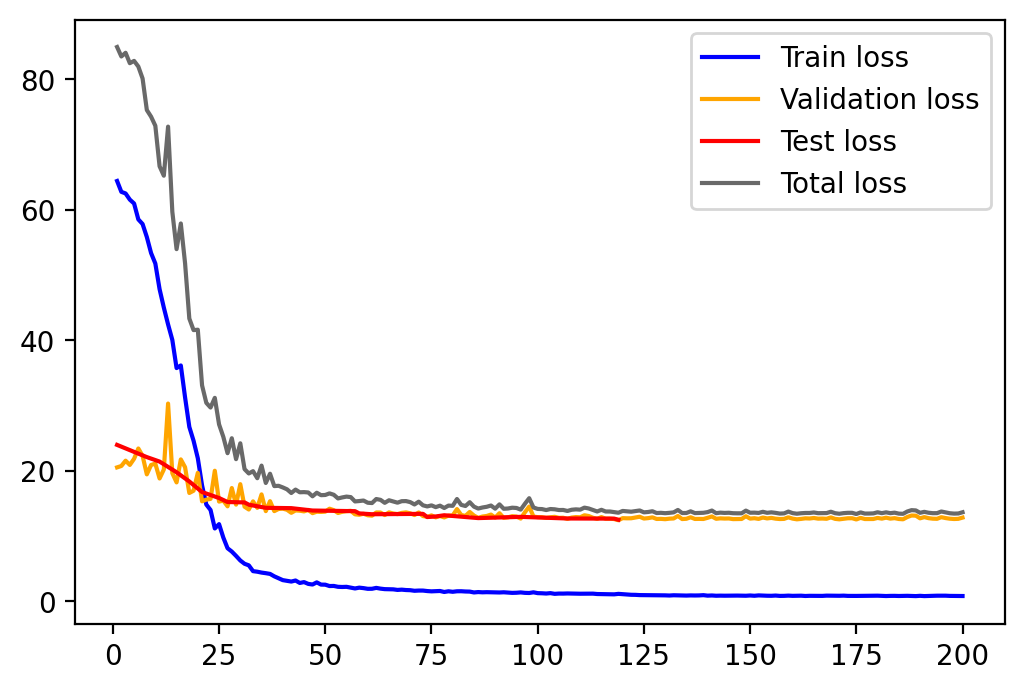

In [8]:
print("Train Loss: {:.4f} | Valid Loss: {:.4f} | Test Loss on Best Model: {:.4f}".format(besttrloss, bestvalloss, besttsloss))
plt.plot(ep,trainloss,color='blue', label = 'Train loss')
plt.plot(ep, validloss, color = 'orange',label = 'Validation loss')
plt.plot(testep, testloss, color = 'red',label = 'Test loss')
plt.plot(ep, totloss, color = 'dimgray',label = 'Total loss')
plt.legend()
plt.show()

In [25]:
tsloss = 0
model.load_state_dict(torch.load('state_dict_ts3_2.pt'))
model.eval()
with torch.no_grad():
    for batch_idx, (data, targets, _) in enumerate(test_loader):
        data = Variable(data).to(device)
        targets = Variable(targets.view(targets.shape[0],-1)).to(device)

        
        scores = model(data)
        loss = criterion(scores, targets)

        if batch_idx == 0:
            true_scores = targets.cpu().numpy()
            pred_scores = scores.cpu().numpy()
        else:
            true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)
            pred_scores = np.append(pred_scores, scores.cpu().numpy(), axis = 0)


        tsloss += loss.item()


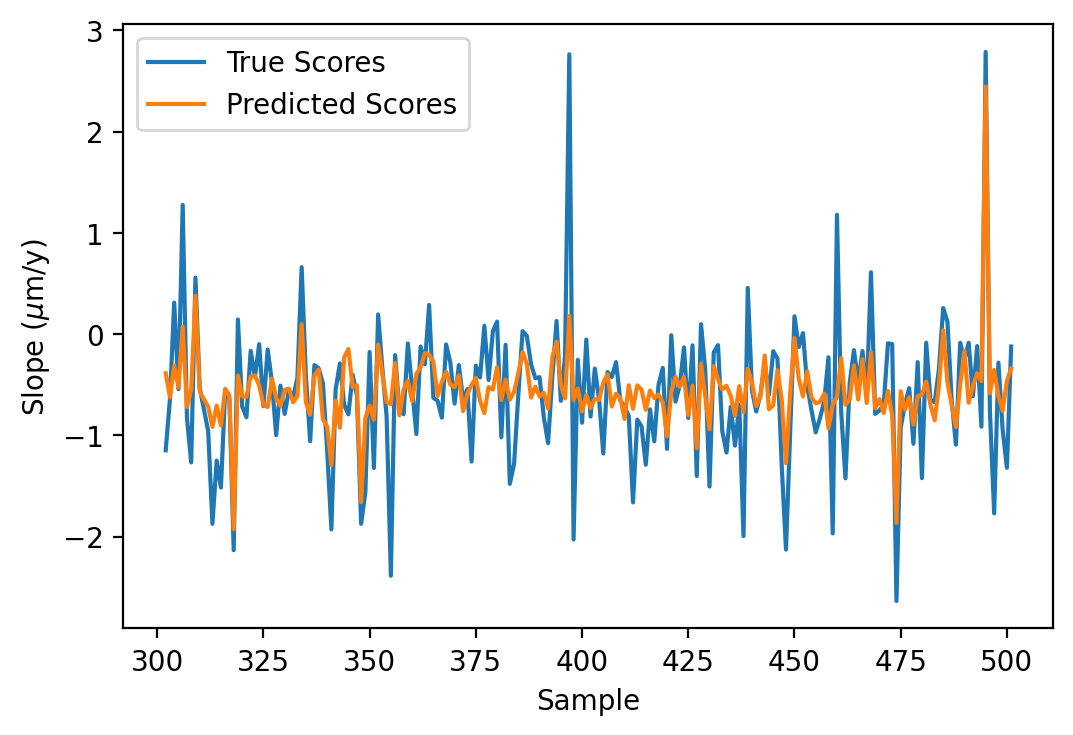

In [26]:
idx = np.array([i+1 for i in range(len(true_scores))])
size = 200
r = np.random.randint(len(idx)-size)
plt.plot(idx[r:r+size], true_scores[r:r+size], label = "True Scores")
plt.plot(idx[r:r+size], pred_scores[r:r+size],label = "Predicted Scores")
plt.ylabel('Slope ($\mu$m/y)')
plt.xlabel('Sample')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Slope ($\\mu$m/y)', ylabel='Count'>

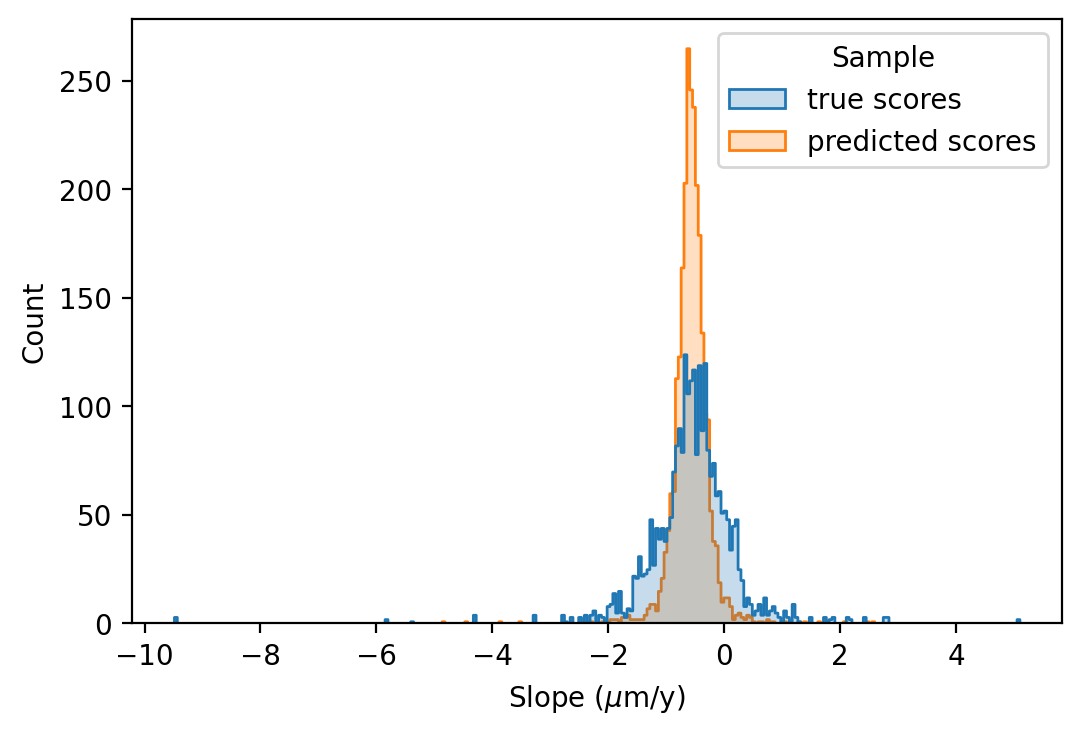

In [27]:
from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': true_scores.ravel().tolist(), 'Sample':'true scores'})
dfy = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': pred_scores.ravel().tolist(), 'Sample':'predicted scores'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='Slope ($\mu$m/y)',hue='Sample',ax=ax, element='step')


In [28]:
print(ks_2samp(true_scores.ravel().tolist(),pred_scores.ravel().tolist()))

KstestResult(statistic=0.20139157325086973, pvalue=2.682421216562942e-46)


In [29]:
df.to_csv('predscores.csv')

In [30]:
ndf = pd.DataFrame({'ep': ep,
'train': trainloss,
'valid': validloss,'total':totloss})
ndf.to_csv('losses.csv')

ndf = pd.DataFrame({'ep': testep, 'test':testloss})
ndf.to_csv('testl.csv')

In [31]:
import pandas as pd
import numpy as np

In [32]:
df = pd.read_csv('predscores.csv')

In [33]:
true = np.array(df[df['Sample'] == 'true scores']['Slope ($\mu$m/y)'].tolist())

In [34]:
pred = np.array(df[df['Sample'] == 'predicted scores']['Slope ($\mu$m/y)'].tolist())

In [35]:
from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(true, pred)

In [36]:
coefficient_of_dermination

0.48126159731374196

In [37]:
import scipy
def rsquared(x, y):

    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

In [38]:
rsquared(true, pred)

0.5812668813295007

In [39]:
scipy.stats.spearmanr(true, pred)

SpearmanrResult(correlation=0.6785886760476748, pvalue=0.0)

In [24]:
scipy.stats.pearsonr(true, pred)

(0.7624086051479902, 0.0)